In [4]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Data_processing')
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import KOProcessor  # Assuming your data processing script is saved as 'data_processing.py'
import networkx as nx
from pyvis.network import Network
from bioservices import KEGG
import multiprocessing
import warnings
import logging

In [5]:
# Load and preprocess data
terms_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_KO.zip'
terms_csv_path = 'terms_KO.csv'
traits_reduced_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
traits_reduced_csv_path = 'reducedDataset.csv'
traits_assembled_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/assembledDataset.zip'
traits_assembled_csv_path = 'assembledDataset.csv'

processor = KOProcessor(
    terms_zip_path, 
    terms_csv_path, 
    traits_reduced_zip_path, 
    traits_reduced_csv_path, 
    traits_assembled_zip_path=traits_assembled_zip_path, 
    traits_assembled_csv_path=traits_assembled_csv_path
)

# Load and preprocess KO terms and traits
target_trait = "gram"

ko_terms = processor.load_terms()
if ko_terms is None:
        raise FileNotFoundError("KO terms could not be loaded. Please check the file paths.")

reduced_traits_data = processor.load_reduced_traits_data()
if reduced_traits_data is None:
    raise FileNotFoundError("Reduced traits data could not be loaded. Please check the file paths.")

# Debug: Print columns of reduced_traits_data
print("Columns in reduced_traits_data:", reduced_traits_data.columns.tolist())

# Uses assembled dataset if data not in reduced
traits_assembled = processor.load_assembled_traits_data()
if traits_assembled is not None:
    print("Columns in assembled_traits_data:", traits_assembled.columns.tolist())

#Feature_preprocess = processor.preprocess_features(ko_terms,reduced_traits_data)

# Preprocess KO terms and traits (trophy, gram, oxygen)
X_terms = processor.preprocess_terms(ko_terms)
y_traits = processor.preprocess_traits(reduced_traits_data, trait_column=target_trait, use_assembled_if_missing=True)

# Check if y_traits was processed correctly
if y_traits is None:
    raise ValueError(f"Traits data for {target_trait} could not be processed. Please check the log for errors.")

# Align features and labels
X_aligned, Y_aligned = processor.align_data(X_terms, y_traits)

# Feature Selection: Variance Threshold
selector = VarianceThreshold(threshold=0.04)
X_aligned = selector.fit_transform(X_aligned)

Data loaded successfully:
   Unnamed: 0   key      KO
0           0  1000  K00001
1           1  1000  K13954
2           2  1000  K00003
3           3  1000  K00013
4           4  1000  K00014
Data loaded successfully:
   key        ID                      speciesStrain  \
0    1  592010.0   Abiotrophia defectiva ATCC 49176   
1    1     219.0     Abiotrophia defectiva DSM 9849   
2    2  159837.0       Abyssibacter profundi OUC007   
3    3       NaN  Acanthopleuribacter pedis FYK2218   
4    4  258515.0   Acetanaerobacterium elongatum Z7   

                 speciesStrainComp                genus            genusComp  \
0    abiotrophiadefectivaatcc49176          Abiotrophia          abiotrophia   
1      abiotrophiadefectivadsm9849          Abiotrophia          abiotrophia   
2       abyssibacterprofundiouc007         Abyssibacter         abyssibacter   
3  acanthopleuribacterpedisfyk2218  Acanthopleuribacter  acanthopleuribacter   
4   acetanaerobacteriumelongatumz7  Acetanaerobac

2025-02-24 15:56:32,663 - INFO - Processing trait: gram
2025-02-24 15:56:32,665 - INFO - Binary trait table created with columns: gram_positive, gram_negative


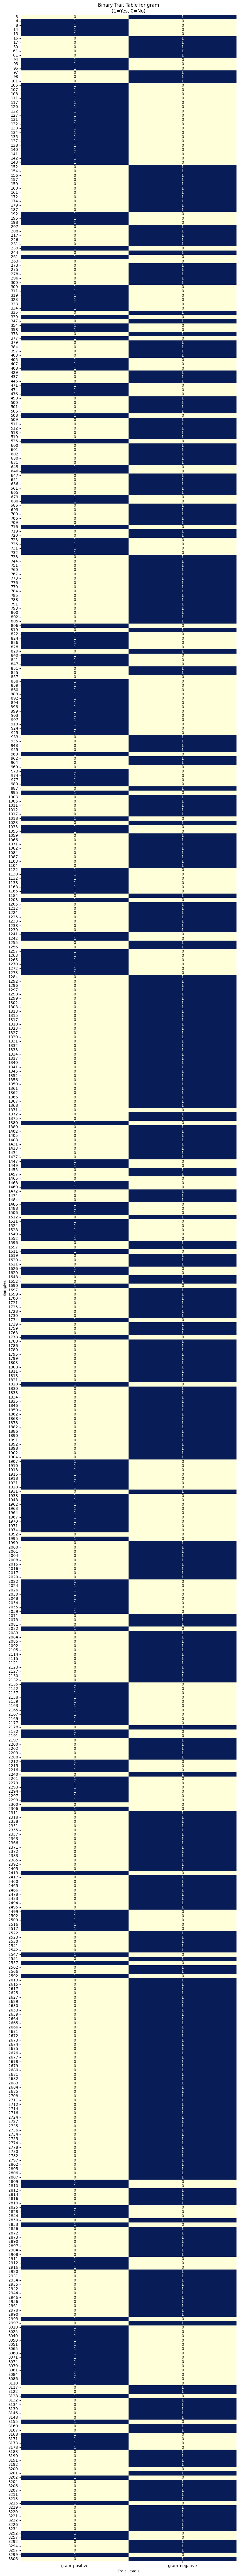

2025-02-24 15:56:36,317 - INFO - Starting grid search with Leave-One-Out cross-validation.


Fitting 594 folds for each of 81 candidates, totalling 48114 fits


2025-02-24 16:17:01,020 - INFO - Best parameters found for gram: {'estimator': RandomForestClassifier(random_state=42), 'estimator__max_depth': 5, 'estimator__n_estimators': 200, 'select_k__k': 100}
2025-02-24 16:17:01,021 - INFO - Best cross-validation score for gram: 0.672
2025-02-24 16:17:17,379 - INFO - Matthews Correlation Coefficient for gram: 0.247


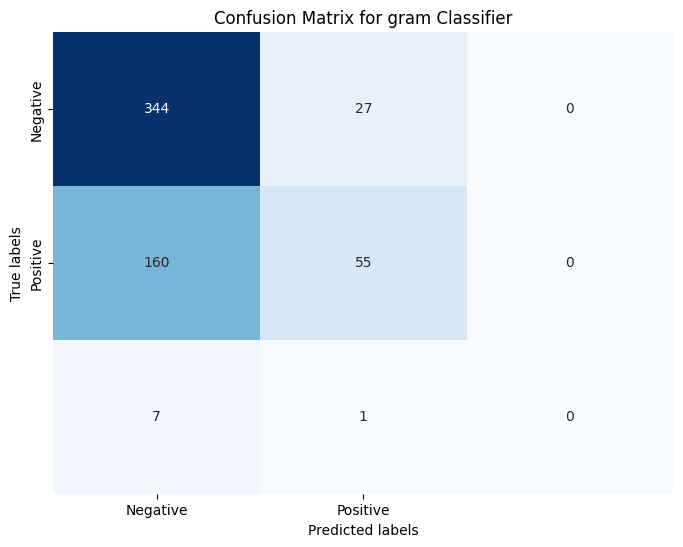

2025-02-24 16:17:17,439 - INFO - Trait: gram
2025-02-24 16:17:17,440 - INFO - Best Parameters: {'estimator': RandomForestClassifier(random_state=42), 'estimator__max_depth': 5, 'estimator__n_estimators': 200, 'select_k__k': 100}
2025-02-24 16:17:17,442 - INFO - Best Cross-Validation Score: 0.672
2025-02-24 16:17:17,443 - INFO - MCC: 0.247
2025-02-24 16:17:17,443 - INFO - Confusion Matrix:
[[344  27   0]
 [160  55   0]
 [  7   1   0]]


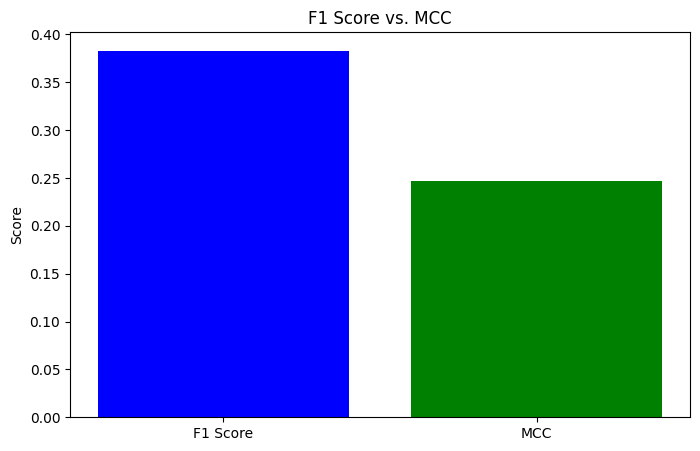

In [6]:

# Configure logging to display timestamps and log levels
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

def create_binary_trait_table(trait_series, trait_name, trait_levels, delimiter=","):
    """
    Converts a trait Series into a binary DataFrame with one column per trait level.
    For each sample, each column is assigned 1 (Yes) if the sample exhibits that level and 0 (No) otherwise.
    
    This function works even if the trait value could contain multiple levels (e.g. "positive, negative")
    so that you always get a column for every possible level.
    
    Parameters:
    - trait_series: pd.Series of trait values (one per sample).
    - trait_name: Name of the trait (e.g., "gram").
    - trait_levels: List of all possible levels (e.g., ["positive", "negative"]).
    - delimiter: Delimiter used in case the trait contains multiple values in a string.
    
    Returns:
    - DataFrame with columns named "{trait_name}_{level}".
    """
    binary_df = pd.DataFrame(index=trait_series.index)
    for level in trait_levels:
        col_name = f"{trait_name}_{level}"
        def check_level(x):
            if pd.isnull(x):
                return 0
            # If the value is a list, check membership
            if isinstance(x, list):
                return 1 if level in x else 0
            # Otherwise assume it's a string and split by the delimiter
            parts = [p.strip() for p in str(x).split(delimiter)]
            return 1 if level in parts else 0
        binary_df[col_name] = trait_series.apply(check_level)
    return binary_df

def train_and_evaluate(X_aligned, Y_aligned, target_trait, trait_levels):
    results = {}
    logging.info(f"Processing trait: {target_trait}")
    
    # Ensure Y is a one-dimensional array
    Y_current = Y_aligned.values.flatten()
    
    # --- Create a Binary Trait Table ---
    # For each microbe, this table will include one column per trait level
    # e.g., for "gram", you'll have "gram_positive" and "gram_negative"
    binary_table = create_binary_trait_table(Y_aligned, target_trait, trait_levels)
    logging.info("Binary trait table created with columns: " + ", ".join(binary_table.columns))
    
    # Display the binary trait table as a heatmap
    plt.figure(figsize=(max(10, binary_table.shape[1]*1.5), max(4, binary_table.shape[0]*0.2)))
    sns.heatmap(binary_table, annot=True, fmt="d", cmap='YlGnBu', cbar=False)
    plt.title(f"Binary Trait Table for {target_trait}\n(1=Yes, 0=No)")
    plt.xlabel("Trait Levels")
    plt.ylabel("Samples")
    plt.show()
    
    # --- Define the Machine Learning Pipeline ---
    pipeline = Pipeline([
        ('select_k', SelectKBest(f_classif)),
        ('variance_threshold', VarianceThreshold(threshold=0.0)),
        ('estimator', RandomForestClassifier())
    ])

    # Parameter grid for grid search (this example includes multiple estimators)
    param_grid = [
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [RandomForestClassifier(random_state=42)],
            'estimator__n_estimators': [100, 200],
            'estimator__max_depth': [5, 10, None]
        },
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [SVC(random_state=42)],
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto']
        },
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [LogisticRegression(max_iter=1000)],
            'estimator__C': [0.01, 0.1, 1, 10, 100]
        },
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [BernoulliNB()],
            'estimator__alpha': [0.01, 0.1, 1.0, 10.0],
            'estimator__binarize': [0.0]
        }
    ]
    
    # --- Grid Search with Leave-One-Out Cross-Validation ---
    loo = LeaveOneOut()
    logging.info("Starting grid search with Leave-One-Out cross-validation.")
    grid_search = GridSearchCV(pipeline, param_grid, cv=loo, n_jobs=-1, verbose=1)
    grid_search.fit(X_aligned, Y_current)
    
    logging.info(f"Best parameters found for {target_trait}: {grid_search.best_params_}")
    logging.info(f"Best cross-validation score for {target_trait}: {grid_search.best_score_:.3f}")

    # --- Predictions Using cross_val_predict ---
    best_model = grid_search.best_estimator_
    Y_pred = cross_val_predict(best_model, X_aligned, Y_current, cv=loo, n_jobs=-1)
    mcc = matthews_corrcoef(Y_current, Y_pred)
    logging.info(f"Matthews Correlation Coefficient for {target_trait}: {mcc:.3f}")

    # --- Confusion Matrix Heatmap ---
    cm = confusion_matrix(Y_current, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {target_trait} Classifier')
    plt.show()
    
    # --- Store and Log the Results ---
    results[target_trait] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'mcc': mcc,
        'confusion_matrix': cm
    }

    logging.info(f"Trait: {target_trait}")
    logging.info(f"Best Parameters: {results[target_trait]['best_params']}")
    logging.info(f"Best Cross-Validation Score: {results[target_trait]['best_score']:.3f}")
    logging.info(f"MCC: {results[target_trait]['mcc']:.3f}")
    logging.info(f"Confusion Matrix:\n{results[target_trait]['confusion_matrix']}")

    # --- F1 Score vs. MCC Bar Chart ---
    f1 = f1_score(Y_current, Y_pred, average='macro')
    plt.figure(figsize=(8, 5))
    plt.bar(['F1 Score', 'MCC'], [f1, mcc], color=['blue', 'green'])
    plt.ylabel('Score')
    plt.title('F1 Score vs. MCC')
    plt.show()

# Example usage:
# For the 'gram' trait, suppose the valid levels are 'positive' and 'negative'
target_trait = "gram"
trait_levels = ['positive', 'negative']  # For other features, simply update this list accordingly.

# X_aligned and Y_aligned are assumed to have been created and aligned earlier in your pipeline
train_and_evaluate(X_aligned, Y_aligned, target_trait, trait_levels)


In [3]:
# Updated train_and_evaluate function using Leave-One-Out Cross-Validation
def train_and_evaluate(X_aligned, Y_aligned):
    results = {}
    print(f"Processing trait: {target_trait}")
    
    # Binary labels for the current trait
    Y_current = Y_aligned.values.flatten()
    
    # Define a pipeline
    pipeline = Pipeline([
        ('select_k', SelectKBest(f_classif)),
        ('variance_threshold', VarianceThreshold(threshold=0.0)),
        ('estimator', RandomForestClassifier())
    ])

    # Define a parameter grid to search over
    param_grid = [
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [RandomForestClassifier(random_state=42)],
            'estimator__n_estimators': [100, 200],
            'estimator__max_depth': [5, 10, None]
        },
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [SVC(random_state=42)],
            'estimator__C': [0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto']
        },
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [LogisticRegression(max_iter=1000)],
            'estimator__C': [0.01, 0.1, 1, 10, 100]
        },
        {
            'select_k__k': [10, 100, 1000],
            'estimator': [BernoulliNB()],
            'estimator__alpha': [0.01, 0.1, 1.0, 10.0],
            'estimator__binarize': [0.0]
        }
    ]
    
    # Grid search with Leave-One-Out cross-validation using multiple CPU cores
    loo = LeaveOneOut()
    grid_search = GridSearchCV(pipeline, param_grid, cv=loo, n_jobs=-1, verbose=1)
    grid_search.fit(X_aligned, Y_current)

    print(f"Best parameters found for {target_trait}:", grid_search.best_params_)
    print(f"Best cross-validation score for {target_trait}: {grid_search.best_score_:.3f}")

    # Use cross_val_predict to get predictions
    best_model = grid_search.best_estimator_
    Y_pred = cross_val_predict(best_model, X_aligned, Y_current, cv=loo, n_jobs=-1)

    mcc = matthews_corrcoef(Y_current, Y_pred)
    print(f"Matthews Correlation Coefficient for {target_trait}: {mcc:.3f}")

    # Display confusion matrix
    cm = confusion_matrix(Y_current, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {target_trait} Classifier')
    plt.show()
    
    # Store results
    results[target_trait] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'mcc': mcc,
        'confusion_matrix': cm
    }

    # Print final results
    print(f"Trait: {target_trait}")
    print(f"Best Parameters: {results[target_trait]['best_params']}")
    print(f"Best Cross-Validation Score: {results[target_trait]['best_score']:.3f}")
    print(f"MCC: {results[target_trait]['mcc']:.3f}")
    print(f"Confusion Matrix:\n{results[target_trait]['confusion_matrix']}\n")

    # F1 Score vs. MCC Graph
    f1 = f1_score(Y_current, Y_pred, average='macro')
    plt.figure(figsize=(8, 5))
    plt.bar(['F1 Score', 'MCC'], [f1, mcc], color=['blue', 'green'])
    plt.ylabel('Score')
    plt.title('F1 Score vs. MCC')
    plt.show()

# Run the function with your data
train_and_evaluate(X_aligned, Y_aligned)

Processing trait: gram
Fitting 594 folds for each of 81 candidates, totalling 48114 fits


KeyboardInterrupt: 

In [ ]:
# KEGG Pathway Mapping
def map_ko_to_pathways(ko_terms):
    kegg = KEGG()
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = X_terms.columns[selector.get_support()]
pathways = map_ko_to_pathways(selected_important_features)

# Creating the adjacency matrix with translated KO terms, including original KO term
translated_kos = {ko: f"Translated_{ko}" for ko in selected_important_features}  # Placeholder for actual translation function
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
kegg = KEGG()
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title(f'Adjacency Matrix of KO Terms and Pathways ({trait_column})')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Network Visualization
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading=f'Interactive Network of KO Terms and Pathways ({trait_column})', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])
nt.save_graph(f"ko_network_{trait_column}.html")
